In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from functools import lru_cache

In [64]:
PATH = os.getcwd()
DATAPATH = os.path.join(PATH, "data")
filenames = {
    "X_test": "test_in - Copy.csv",
    "X_train": "train_in - Copy.csv",
    "y_test": "test_out - Copy.csv",
    "y_train": "train_out - Copy.csv",
}


# Import all data files
X_train = pd.read_csv(os.path.join(DATAPATH, filenames["X_train"]), header=None)
y_train = pd.read_csv(
    os.path.join(DATAPATH, filenames["y_train"]), header=None, names=["digit"]
)
X_test = pd.read_csv(os.path.join(DATAPATH, filenames["X_test"]), header=None)
y_test = pd.read_csv(
    os.path.join(DATAPATH, filenames["y_test"]), header=None, names=["digit"]
)

In [65]:
@lru_cache()
def tanh(x):
    return np.tanh(x)


@lru_cache()
def dtanh(x):
    return np.cosh(x) ** -2


def softmax(x):
    return np.exp(x) / (np.exp(x)).sum(axis=0)

@lru_cache()
def sigmoid(x):
    return (1 + np.exp(-x)) ** -1


@lru_cache()
def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


def random_weights(shape, bounds=[-1, 1]):
    return pd.DataFrame(np.random.uniform(*bounds, size=shape))

In [66]:
expected = np.zeros((len(X_train), 10))
for i, digit in enumerate(y_train.digit):
    expected[i, digit] = 1


def append_one(X):
    return pd.concat(
        [X, pd.DataFrame(np.ones(X.shape[0]), columns=[256], index=X.index)], axis=1
    )


def grd_desc(
    inputs: pd.DataFrame,
    expected: pd.DataFrame,
    weights: pd.DataFrame,
    actf=sigmoid,
    dactf=dsigmoid,
):
    gradient = pd.DataFrame(np.zeros(weights.shape))
    w_x = append_one(inputs) @ weights
    gradient += append_one(inputs).T @ (
        2 * (w_x.applymap(actf) - expected) * w_x.applymap(dactf)
    )
    return gradient


def classify(weights, X=X_test, actf=sigmoid):
    y_out = (append_one(X) @ weights).applymap(actf)
    return y_out.apply(np.argmax, axis=1)


def mse(weights, X, expected, actf=sigmoid):
    return (
        (((append_one(X) @ weights).applymap(actf) - expected) ** 2).sum(axis=1).sum()
    )

def logerp(a, b, t, base=10):
    return np.log((1-t)*pow(base, a) + t * pow(base, b))/np.log(base)

# expected = np.zeros((len(X_train), 10))
# for i, digit in enumerate(y_train.digit):
#     expected[i, digit] = 1
# expected = pd.DataFrame(expected)
# ids = np.random.choice(X_train.shape[0], X_train.shape[0]//10)
# grd_desc(X_train.iloc[ids], expected.iloc[ids], random_weights((257, 10)))

100%|██████████| 10000/10000 [36:55<00:00,  4.51it/s] 


Final training mse: 1280.0000081388034
Final testing mse: 748.7306464448982
accuraccy on train data: 0.441
accuraccy on test data: 0.457


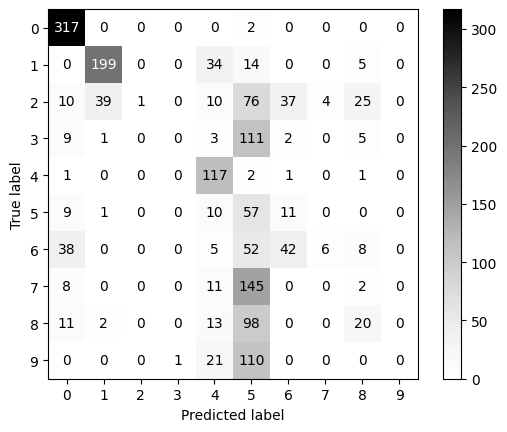

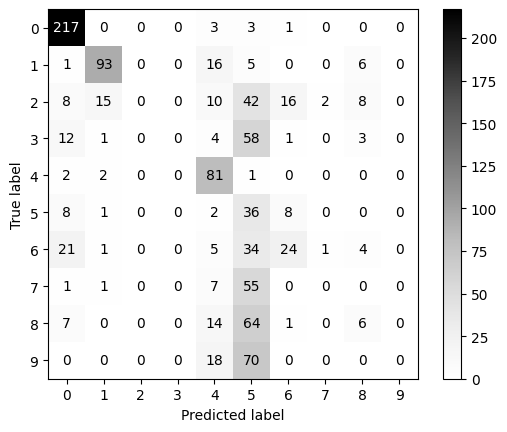

In [75]:
def train_perceptron(
    eta=0.01,
    n_loops=1000,
    initial_weights=None,
    X: pd.DataFrame = X_train,
    y: pd.DataFrame = y_train,
    actf=sigmoid,
    dactf=dsigmoid,
    show: bool = True,
    stochastic: bool = False,
    k: int = 10,
    l: int = 10,
    experimental: bool = False,
    eta_begin: float = 0.1,
    eta_final: float = 0.001,
):
    expected = np.zeros((len(X), 10))
    for i, digit in enumerate(y.digit):
        expected[i, digit] = 1
    expected = pd.DataFrame(expected)

    weights = random_weights((X.shape[1] + 1, 10)) if initial_weights is None else initial_weights
    for epoch in tqdm(range(n_loops)):
        if experimental:
            eta = logerp(eta_begin, eta_final, epoch / n_loops)
        if stochastic:
            # only use a small batch of the input and expected
            all_idx = np.arange(X.shape[0])
            np.random.shuffle(all_idx)
            for ids in np.array_split(all_idx, k)[:l]:
                weights -= eta * grd_desc(
                    X.iloc[ids], expected.iloc[ids], weights, actf, dactf
                )
        else:
            weights -= eta * grd_desc(X, expected, weights, actf, dactf)

        # if show and epoch % (n_loops // 10) == 0:
        #     print(
        #         f"Epoch {epoch:{int(np.log10(n_loops))+1}}, mse: {mse(weights, X, expected, actf):.3f}"
        #     )

    return weights


weights = train_perceptron(
    eta=1,
    initial_weights=weights
    n_loops=10000,
    experimental=True,
    stochastic=True,
    eta_begin=1,
    eta_final=0.001,
    k=100,
    l=19,
)
expected = np.zeros((len(X_train), 10))
for i, digit in enumerate(y_train.digit):
    expected[i, digit] = 1
expected = pd.DataFrame(expected)
print(f"Final training mse: {mse(weights, X_train, expected)}")
expected = np.zeros((len(X_test), 10))
for i, digit in enumerate(y_test.digit):
    expected[i, digit] = 1
expected = pd.DataFrame(expected)
print(f"Final testing mse: {mse(weights, X_test, expected)}")

y_out = classify(weights, X_train)
acc = sum(y_out.eq(y_train.digit)) / len(y_out)
ConfusionMatrixDisplay(confusion_matrix(y_train.digit, y_out)).plot(cmap="Greys")
print(f"accuraccy on train data: {acc:.3f}")

y_out = classify(weights, X_test)
acc = sum(y_out.eq(y_test.digit)) / len(y_out)
ConfusionMatrixDisplay(confusion_matrix(y_test.digit, y_out)).plot(cmap="Greys")
print(f"accuraccy on test data: {acc:.3f}")